# Difference in Palermo Scale between Large and Small Asteroids

### Introduction

Asteroids, meteorites flying through space, are important to track as the ones that have collided with the earth in the past have critically changed the Earth’s biosphere (Yeomans 1998) and its craters have been important analytical tools to explain our solar systems past (AMNH n.a). With the danger that a large asteroid could bring to earth, planetary defence analytics is important, and knowing out to prioritise which near-earth objects to look out for is essential in a time crunch (Yeomans 1998). Our inferential question is whether the magnitude of an asteroid affects the Palermo_Scale of the asteriod. The palermo scale is a logarithmic scale used by astronomers to rate the potential hazard of impact of a near-Earth object. It combines two types of data—probability of impact and estimated kinetic yield—into a single "hazard" value. Given our question, the population of interest will be the asteroids that have currently been prioritised analytically to have a possibility of intersecting with the earth’s trajectory over a 100 year period. Our null hypothesis is that there is no difference in the Palermo scale between large and small asteroids. We will be splitting up the asteroids into two magnitude groups from the data we collected from the Possible Asteroid Impacts with Earth dataset posted on Kaggle.




### Preliminary Results

In [38]:
library(tidyverse)
library(broom)
library(infer)


In [39]:
url <- 'https://raw.githubusercontent.com/arulh/STAT-201-project/main/data/impacts.csv'
df <- read.csv(
    url
)


In [40]:
head(df)

,Object.Name,Period.Start,Period.End,Possible.Impacts,Cumulative.Impact.Probability,Asteroid.Velocity,Asteroid.Magnitude,Asteroid.Diameter..km.,Cumulative.Palermo.Scale,Maximum.Palermo.Scale,Maximum.Torino.Scale
,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2006 WP1,2017,2017,1,5.2e-09,17.77,28.3,0.007,-8.31,-8.31,0
2,2013 YB,2017,2046,23,7.6e-05,8.98,31.4,0.002,-6.60,-6.96,0
3,2008 US,2017,2062,30,1.6e-05,18.33,31.4,0.002,-6.48,-6.87,0
4,2010 VR139,2017,2076,24,2.0e-07,4.99,26.7,0.016,-6.83,-6.95,0
5,2015 ME131,2017,2096,85,2.3e-08,19.46,19.2,0.497,-3.85,-4.30,0
6,2010 XB73,2017,2110,55,2.8e-07,5.98,22.5,0.110,-5.03,-5.51,0


Here we are creating a new column called asteroid_size. The values are "large" if the Asteroid is larger than the median asteroid magnitude and "small" if smaller or equal to the Median Magnitude. This is needed when coming up with our hypothesis test.

In [41]:
median_magnitude <- median(df$Asteroid.Magnitude)
median_magnitude

df <- df %>%
    mutate(asteroid_size = if_else(df$Asteroid.Magnitude > median_magnitude, 'large', 'small')) %>%
    mutate(Maximum.Palermo.Scale = abs(Maximum.Palermo.Scale)) %>%
    select(asteroid_size, Maximum.Palermo.Scale) 

head(df)

[1] 26.4

,asteroid_size,Maximum.Palermo.Scale
,<chr>,<dbl>
1,large,8.31
2,large,6.96
3,large,6.87
4,large,6.95
5,small,4.30
6,small,5.51


In [42]:
### Getting Location and Scale Parameters

In [43]:
# Getting the mean Palermo Scale for the two groups (large and small asteroid)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}



mean_values <- df %>%
    group_by(asteroid_size) %>%
    summarize(sample_size = n(),
            mean_Palermo_Scale = mean(Maximum.Palermo.Scale),
             median_Palermo_Scale = median(Maximum.Palermo.Scale),
             mode_Palermo_Scale = getmode(Maximum.Palermo.Scale),
             twenty_fifth_percentile = quantile(Maximum.Palermo.Scale, probs = .25),
             seventy_fifth_percentile = quantile(Maximum.Palermo.Scale, probs = .75),
             standard_deviation = sd(Maximum.Palermo.Scale),
             inter_quartile_range_50 = seventy_fifth_percentile - twenty_fifth_percentile)

mean_values


asteroid_size,sample_size,mean_Palermo_Scale,median_Palermo_Scale,mode_Palermo_Scale,twenty_fifth_percentile,seventy_fifth_percentile,standard_deviation,inter_quartile_range_50
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
large,340,7.269176,7.25,7.50,6.35,8.0825,1.335189,1.7325
small,343,6.342915,6.34,6.43,5.38,7.3100,1.466209,1.9300


In [44]:
## Getting Histogram for both large and small asteroids

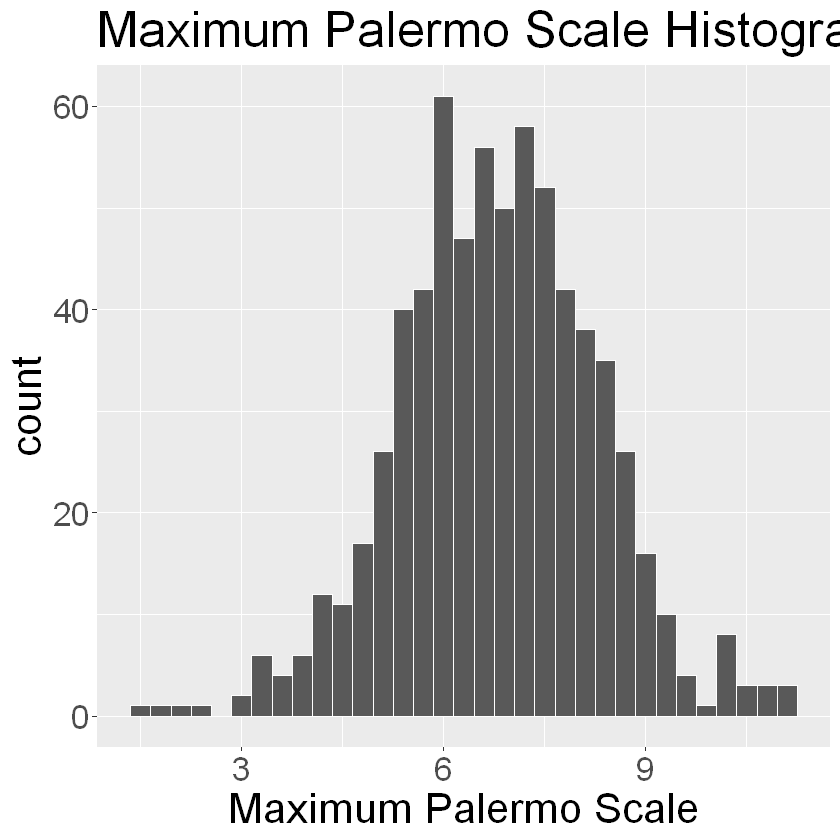

In [45]:
histogram <- 
    df %>% 
    ggplot() + 
    geom_histogram(aes(x=Maximum.Palermo.Scale), binwidth = 0.3, color="white") +
    xlab("Maximum Palermo Scale") + 
    theme(text = element_text(size=25)) + 
    ggtitle("Maximum Palermo Scale Histogram")

histogram

In [46]:
## Getting Boxplot for both large and small asteroids

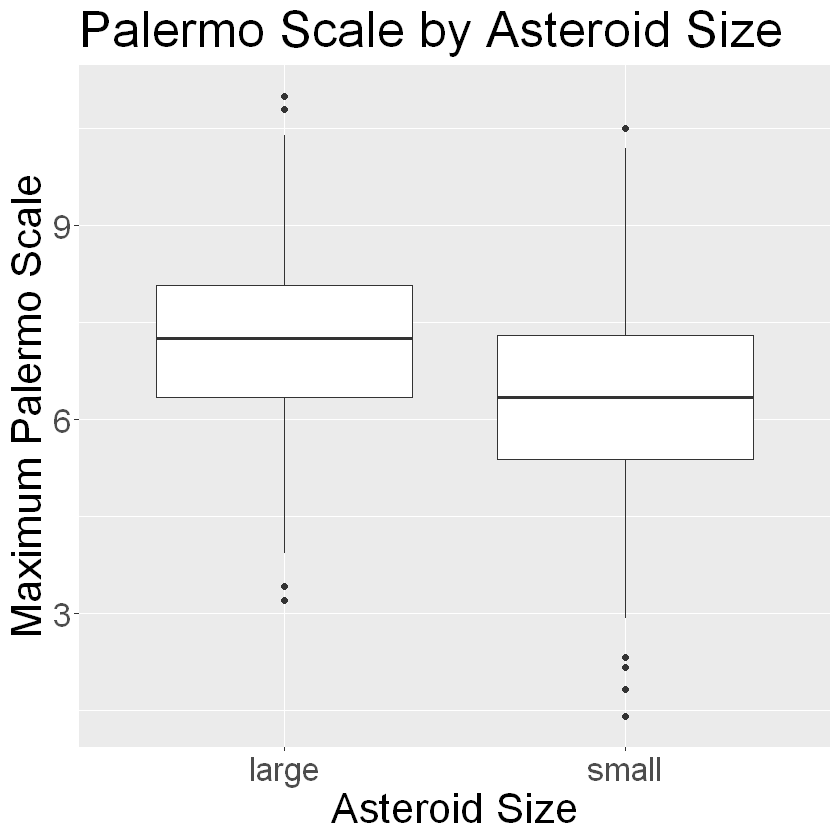

In [47]:
boxplots <- 
   df %>%  
   ggplot(aes(x = asteroid_size, y = Maximum.Palermo.Scale)) + 
   geom_boxplot() + 
   ylab("Maximum Palermo Scale") +
   ggtitle("Palermo Scale by Asteroid Size") +
    xlab("Asteroid Size") +
   theme(text = element_text(size=25))

boxplots

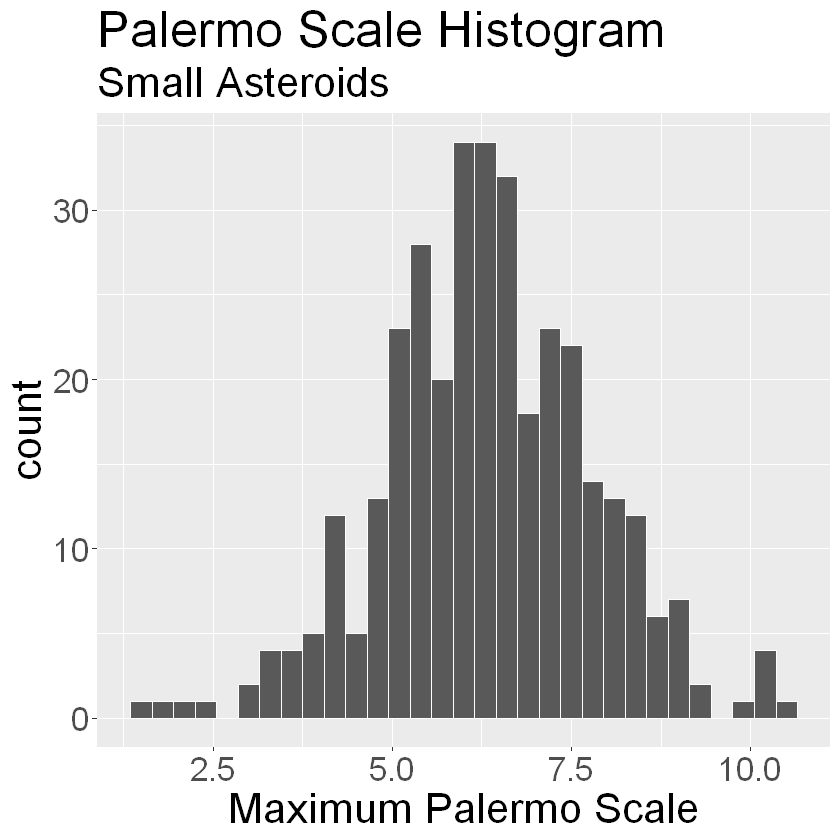

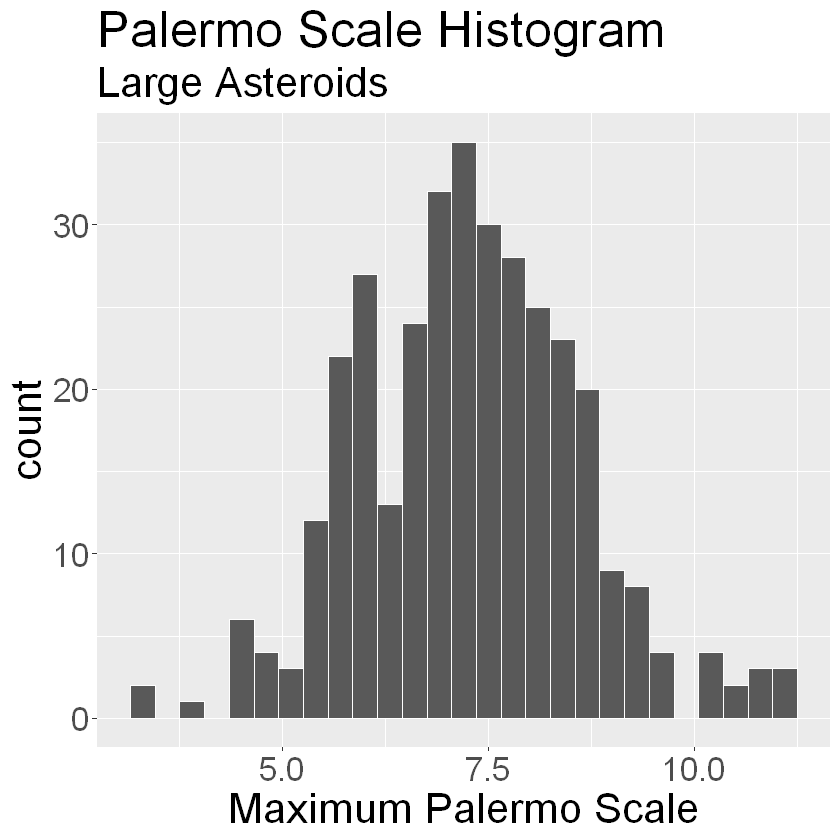

In [48]:
histogram_small_asteroid <- 
    df %>% 
    filter(asteroid_size == "small") %>%
    ggplot() + 
    geom_histogram(aes(x=Maximum.Palermo.Scale), binwidth = 0.3, color="white") +
    xlab("Maximum Palermo Scale") + 
    theme(text = element_text(size=25)) + 
    ggtitle("Palermo Scale Histogram", subtitle = "Small Asteroids")


histogram_large_asteroid <- 
    df %>% 
    filter(asteroid_size == "large") %>%
    ggplot() + 
    geom_histogram(aes(x=Maximum.Palermo.Scale), binwidth = 0.3, color="white") +
    xlab("Maximum Palermo Scale") + 
    theme(text = element_text(size=25)) + 
    ggtitle("Palermo Scale Histogram", subtitle = "Large Asteroids")

histogram_small_asteroid
histogram_large_asteroid



In [49]:
### Bootstrap Distribution

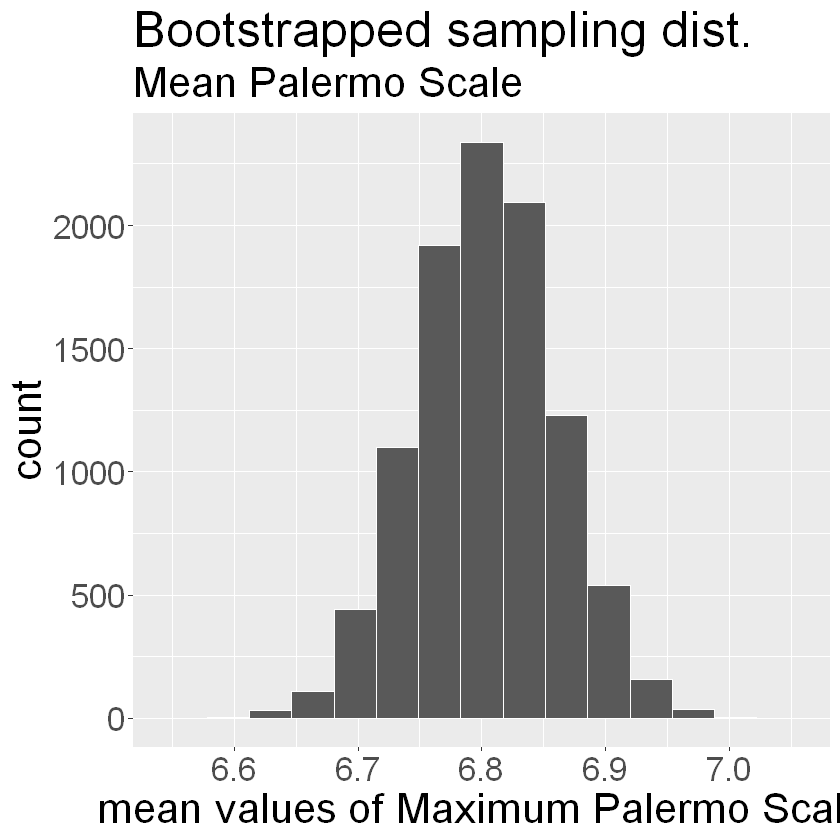

In [50]:
set.seed(1)

sample_dist <- 
    df %>% 
    specify(response = Maximum.Palermo.Scale) %>% 
    generate(type = "bootstrap", reps = 10000) %>% 
    calculate(stat = "mean")

bootstrap_dist <- 
    sample_dist %>% 
    ggplot() + 
    geom_histogram(aes(x=stat), bins = 15, color="white") +
    xlab("mean values of Maximum Palermo Scale") + 
    theme(text = element_text(size=25)) + 
    ggtitle("Bootstrapped sampling dist.", subtitle = "Mean Palermo Scale")
# your code here

bootstrap_dist

From the maximum Palermo scale of large and small asteroids, we will perform a hypothesis test to conclude whether the large asteroid has a larger chance of impact on the earth than smaller asteroids:

The two hypothesis are:

- $H_0: \mu_{large} - \mu_{small} = 0$
- $H_a: \mu_{large} - \mu_{small} > 0$

Since the asteroids are different and independent of each other, we will be performing a two-sample t-test on each large or small asteroids.


In [53]:
# Determining the test statistic

large_asteroids <- df |>
    filter(asteroid_size == "large")

small_asteroids <- df |>
    filter(asteroid_size == "small")

test_statistic <-
    (mean_values$mean_Palermo_Scale[1] - mean_values$mean_Palermo_Scale[2])/sqrt(mean_values$standard_deviation[1]^2/mean_values$sample_size[1] + mean_values$standard_deviation[2]^2/mean_values$sample_size[2])
test_statistic

asteroidttest <-
    tidy(
        t.test(x = large_asteroids$Maximum.Palermo.Scale,
               y = small_asteroids$Maximum.Palermo.Scale,
               alternative = "greater"))

asteroidttest

[1] 8.633349

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.926261,7.269176,6.342915,8.633349,2.128731e-17,676.1635,0.7495446,Inf,Welch Two Sample t-test,greater


In [54]:
mean_max_flow_ci <- 
    sample_dist %>% 
    summarise(lower_ci = quantile(stat, 0.05), upper_ci = quantile(stat, 0.95))

mean_max_flow_ci

lower_ci,upper_ci
<dbl>,<dbl>
6.710643,6.897735


In [81]:
set.seed(1)
obs_diff_in_means <- 
   df %>% 
   specify(formula = Maximum.Palermo.Scale ~ asteroid_size) %>% 
   calculate(stat="diff in means", order = c("large", "small"))


null_diff_in_means <- 
   df %>% 
   specify(formula = Maximum.Palermo.Scale ~ asteroid_size) %>% 
    hypothesize(null = "independence") %>% 
   generate(type="bootstrap", reps = 1000) %>% 
   calculate(stat="diff in means", order = c("large", "small"))

print(obs_diff_in_means)
head(null_diff_in_means)
mean(null_diff_in_means$stat)

Warning message:
"You have given `type = "bootstrap"`, but `type` is expected to be `"permute"`. This workflow is untested and the results may not mean what you think they mean."


Response: Maximum.Palermo.Scale (numeric)
Explanatory: asteroid_size (factor)
# A tibble: 1 x 1
   stat
  <dbl>
1 0.926


replicate,stat
<int>,<dbl>
1,0.9746926
2,0.8921599
3,0.9296438
4,0.8974665
5,0.8761966
6,1.1466677


[1] 0.9215362

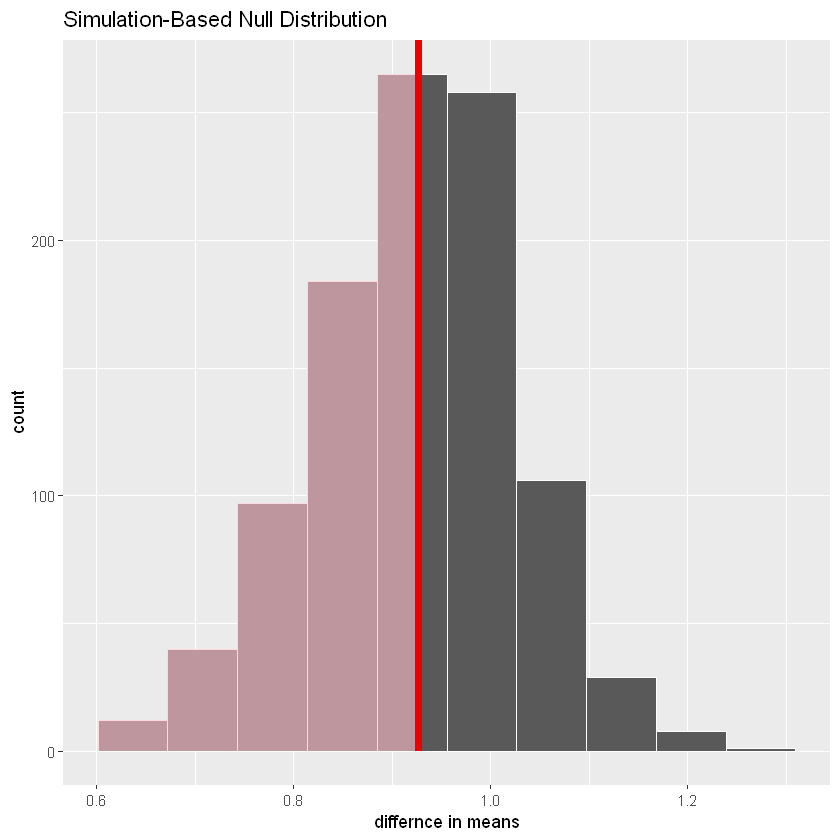

In [63]:
diff_in_means_plot <- 
   null_diff_in_means %>%
   visualize(bins = 10) + 
   shade_p_value(obs_stat = obs_diff_in_means, direction = "left") +
    xlab("differnce in means")

# your code here


diff_in_means_plot

In [65]:
p_value_bootstrap <- null_diff_in_means %>% 
  get_p_value(obs_stat = obs_diff_in_means, direction = "right")

p_value_bootstrap

p_value
<dbl>
0.53


In [73]:
print("80% Confidence Interval:")
ci_80 <- 
    null_diff_in_means %>% 
    summarise(lower_ci = quantile(stat, 0.1), upper_ci = quantile(stat, 0.9))

ci_80

print("95% Confidence Interval:")
ci_95 <- 
    null_diff_in_means %>% 
    summarise(lower_ci = quantile(stat, 0.05), upper_ci = quantile(stat, 0.95))

ci_95

print("99% Confidence Interval:")
ci_99 <- 
    null_diff_in_means %>% 
    summarise(lower_ci = quantile(stat, 0.01), upper_ci = quantile(stat, 0.99))

ci_99

[1] "80% Confidence Interval:"


lower_ci,upper_ci
<dbl>,<dbl>
0.7945991,1.051799


[1] "95% Confidence Interval:"


lower_ci,upper_ci
<dbl>,<dbl>
0.7415225,1.08654


[1] "99% Confidence Interval:"


lower_ci,upper_ci
<dbl>,<dbl>
0.6670248,1.160745


In [79]:
null_std_error <- sqrt((1.335189/340) + (1.466209/343))

In [80]:
p_value <- pnorm(7.269176-6.342915, null_std_error, lower.tail = FALSE)
p_value

[1] 0.2016625

In [68]:
# bream_roach_t_test <-

a <- df %>%
    filter(asteroid_size == "large") %>% select(Maximum.Palermo.Scale)

b <- df %>%
    filter(asteroid_size == "small") %>% select(Maximum.Palermo.Scale)

# # your code here
t_test <- tidy(
    t.test(x=a, y=b, alternative = "greater"))

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.926261,7.269176,6.342915,8.633349,2.128731e-17,676.1635,0.7495446,Inf,Welch Two Sample t-test,greater


### Methods

The Palermo scale was chosen as the metric because it quantifies the relative risk of a NEO over a period of time. It is trustworthy because it is widely recognized by NEO specialists as the predominant metric for quantifying the level of concern. <br>
The Sentry system used to monitor potential asteroid collisions is less accurate at calculating the elliptical path and the trajectory of the smaller asteroids. This may result in the group with the small asteroids not being a good representation of the true risk represented by the Palermo scale. <br>
We expect to find a higher Palermo scale for asteroids with higher magnitude. This could help analysts more quickly recognize possible harmful asteroids vs benign ones based purely on magnitude. This leads to further questions such as what other parameters influence the Palermo scale, and could this analysis apply to other objects floating above Earth, like the 100 trillion trash and satellites (Kluger 2023), that have an equal chance of colliding and causing damage to Earth?


### bootstrapping or asymptotics <br>

Both bootstrapping and asymptotics can be appropriate in different situations, depending on the nature of the data and the research question. Bootstrapping can be useful when the sample size is small or when the population distribution is unknown or non-normal. However in our case we have a very large sample size that has a normal distribution, suggesting that the population distribution is normal as well. Overall we found that the asymptotic method was better since more computationally efficient and easier to implement and explain. However if our data set was small or not normal than bootstrapping would most likely give us a better estimate of the difference in means. <br>

Additionally, bootstrapping relies on resampling from the original data, which means that any biases or errors in the original data will be propagated to the bootstrapped estimates. Asymptotics, on the other hand, relies on mathematical approximations that may not hold true in all situations. Hence although both methods have their pros and cons, we believe that asymptotics is better suited for the problem we have. <br>

Our results from bootstrapping are very similar but the p-value we achieved was different. This may be because bootstrapping samples with replacement from our original dataset. Hence it is possible that the same value was selected multiple times changing the distribution and hence changing the p-value. Additionally the difference in results can be due to the assumptions of using asymptotics may not be met (normal distribution and large sample size).

### Discussion <br>

The p-values we got from 

### References

Kluger, Jeffrey. “Scientists Sound Alarm over a Growing Trash Problem in Space.” Time, Time, 13 Mar. 2023, <br> https://time.com/6262389/space-junk-increasing-problem/.  

“Why Study Impact Craters?: AMNH.” American Museum of Natural History, https://www.amnh.org/exhibitions/permanent/meteorites/meteorite-impacts/earth-impacts/why-study-impact-craters#:~:text=Craters%20are%20windows%20into%20the,geological%20history%20of%20those%20bodies.   

Yeomans, Donald K. “Why Study Asteroids?” NASA, NASA, April. 1998, https://ssd.jpl.nasa.gov/sb/why_asteroids.html#:~:text=The%20scientific%20interest%20in%20asteroids,Earth's%20biosphere%20in%20the%20past.   
